# VIIRS Satellite image generation (AWS data)

**This does not work yet. Will need to adapt Bill Line's VIIRS code.**

In [1]:
#---Cloud search libraries
import s3fs
import requests
import fnmatch

#---Accessory libraries
import datetime
import netCDF4

**Set the datetime and band to view:**

In [2]:
year = 2024
month = 6
day = 20
hour = 6

band = '14' #---Include the leading zero, if needed

julian_day = datetime.datetime(year, month, day).strftime('%j')
print(julian_day)

datetime_str = str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+' '+str(hour).zfill(2)+'Z'

172


**Connecting to AWS remote storage:**

In [3]:
fs = s3fs.S3FileSystem(anon=True)

**Search the AWS database:**

In [4]:
#---NOAA-20
bucket = 'noaa-nesdis-n20-pds'

files = fs.ls(bucket+'/'+'VIIRS-DNB-SDR/'+str(year)+'/'+str(month).zfill(2)+'/'+str(day).zfill(2)+'/')
files_geo = fs.ls(bucket+'/'+'VIIRS-DNB-GEO/'+str(year)+'/'+str(month).zfill(2)+'/'+str(day).zfill(2)+'/')

files_hour = [file for file in files if fnmatch.fnmatch(file.split('/')[-1], 'SVDNB_j01_d'+str(year)+str(month).zfill(2)+str(day)+'_t'+str(hour).zfill(2)+'*')]
files_hour_geo = [file for file in files_geo if fnmatch.fnmatch(file.split('/')[-1], 'GDNBO_j01_d'+str(year)+str(month).zfill(2)+str(day)+'_t'+str(hour).zfill(2)+'*')]

print(files_hour[0])
print(files_hour_geo[0])

noaa-nesdis-n20-pds/VIIRS-DNB-SDR/2024/06/20/SVDNB_j01_d20240620_t0600123_e0601350_b34134_c20240620061221033000_oebc_ops.h5
noaa-nesdis-n20-pds/VIIRS-DNB-GEO/2024/06/20/GDNBO_j01_d20240620_t0600123_e0601350_b34134_c20240620061023832000_oebc_ops.h5


In [5]:
file = files_hour[0]
file_geo = files_hour_geo[0]

resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+file[20:])
if str(resp) != '<Response [200]>':
    print('DNB file not found in AWS servers')

resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+file_geo[20:])
if str(resp) != '<Response [200]>':
    print('DNB GEO file not found in AWS servers')



nc = netCDF4.Dataset(file, memory = resp.content)
nc_geo = netCDF4.Dataset(file_geo, memory = resp.content)

In [6]:
nc.groups['All_Data']['VIIRS-DNB-GEO_All']

<class 'netCDF4._netCDF4.Group'>
group /All_Data/VIIRS-DNB-GEO_All:
    dimensions(sizes): phony_dim_0(768), phony_dim_1(4064), phony_dim_2(48), phony_dim_3(1), phony_dim_4(3)
    variables(dimensions): float32 Height(phony_dim_0, phony_dim_1), float32 Height_TC(phony_dim_0, phony_dim_1), float32 Latitude(phony_dim_0, phony_dim_1), float32 Latitude_TC(phony_dim_0, phony_dim_1), float32 Longitude(phony_dim_0, phony_dim_1), float32 Longitude_TC(phony_dim_0, phony_dim_1), float32 LunarAzimuthAngle(phony_dim_0, phony_dim_1), float32 LunarZenithAngle(phony_dim_0, phony_dim_1), int64 MidTime(phony_dim_2), uint8 ModeGran(phony_dim_3), uint8 ModeScan(phony_dim_2), float32 MoonIllumFraction(phony_dim_3), float32 MoonPhaseAngle(phony_dim_3), int32 NumberOfScans(phony_dim_3), uint8 PadByte1(phony_dim_4), uint8 QF1_SCAN_VIIRSSDRGEO(phony_dim_2), uint8 QF2_SCAN_VIIRSSDRGEO(phony_dim_2), uint8 QF2_VIIRSSDRGEO(phony_dim_0, phony_dim_1), uint8 QF2_VIIRSSDRGEO_TC(phony_dim_0, phony_dim_1), float32 SCAt

**Second attempt:**
* Source: https://github.com/baracoma/public_notebooks/blob/master/plot_VIIRS.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cartopy.crs as ccrs
import os

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

In [2]:
VIIRS_path = 'viirs_data/'
viirs_path = os.path.join(VIIRS_path,
                          'VNP46A1.A2024171.h11v04.001.2024176205911.h5')

In [3]:
viirs_ds = h5py.File(viirs_path, 'r')


In [4]:
viirs_ds.keys()

<KeysViewHDF5 ['HDFEOS', 'HDFEOS INFORMATION']>

In [5]:
viirs_ds['HDFEOS'].keys()


<KeysViewHDF5 ['ADDITIONAL', 'GRIDS']>

In [6]:
viirs_ds['HDFEOS/GRIDS'].keys()

<KeysViewHDF5 ['VNP_Grid_DNB']>

In [7]:
viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB'].keys()

<KeysViewHDF5 ['Data Fields']>

In [8]:
viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB/Data Fields'].keys()

<KeysViewHDF5 ['BrightnessTemperature_M12', 'BrightnessTemperature_M13', 'BrightnessTemperature_M15', 'BrightnessTemperature_M16', 'DNB_At_Sensor_Radiance_500m', 'Glint_Angle', 'Granule', 'Lunar_Azimuth', 'Lunar_Zenith', 'Moon_Illumination_Fraction', 'Moon_Phase_Angle', 'QF_Cloud_Mask', 'QF_DNB', 'QF_VIIRS_M10', 'QF_VIIRS_M11', 'QF_VIIRS_M12', 'QF_VIIRS_M13', 'QF_VIIRS_M15', 'QF_VIIRS_M16', 'Radiance_M10', 'Radiance_M11', 'Sensor_Azimuth', 'Sensor_Zenith', 'Solar_Azimuth', 'Solar_Zenith', 'UTC_Time']>

In [9]:
dnb = viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB/Data Fields/DNB_At_Sensor_Radiance_500m']

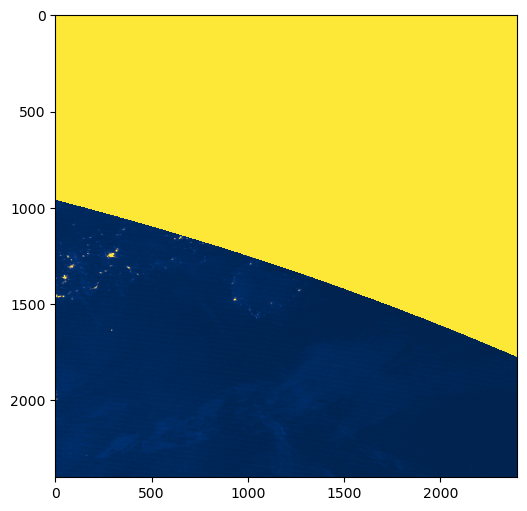

In [10]:
cmap = plt.get_cmap('cividis')

fig =  plt.figure(figsize=(6,6))
ax = plt.axes()

ax.imshow(dnb, cmap = cmap, vmin = 0, vmax = 100)
plt.show()

In [11]:
list(viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB'].attrs)

['CMfill',
 'EastBoundingCoord',
 'HorizontalTileNumber',
 'InputPointer_CM',
 'InputPointer_DNB',
 'InputPointer_L2G_Ang',
 'InputPointer_L2G_DNB',
 'InputPointer_L2G_PNTR',
 'InputPointer_Mod',
 'NorthBoundingCoord',
 'NumberofInputGranules',
 'PGEVersion',
 'PGE_Name',
 'ProcessingEnvironment',
 'RangeBeginningDate',
 'RangeBeginningTime',
 'RangeEndingDate',
 'RangeEndingTime',
 'ReprocessingActual',
 'ReprocessingPlanned',
 'SatelliteInstrument',
 'ScienceQualityFlagExplanation',
 'SouthBoundingCoord',
 'TileID',
 'TileMode',
 'VerticalTileNumber',
 'WestBoundingCoord',
 'useCM']

In [12]:
lat_max = viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB'].attrs['NorthBoundingCoord']
lat_min = viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB'].attrs['SouthBoundingCoord']
lon_max = viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB'].attrs['EastBoundingCoord']
lon_min = viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB'].attrs['WestBoundingCoord']

In [13]:
print('Latitudes: '+str(lat_min[0]) +', '+ str(lat_max[0]))
print('Longitudes: '+str(lon_min[0]) +', '+ str(lon_max[0]))

Latitudes: 40.0, 50.0
Longitudes: -70.0, -59.99999999999999


In [14]:
lats = np.linspace(lat_max, lat_min, dnb.shape[1])
lons = np.linspace(lon_min, lon_max, dnb.shape[0])
x, y = np.meshgrid(lons, lats)

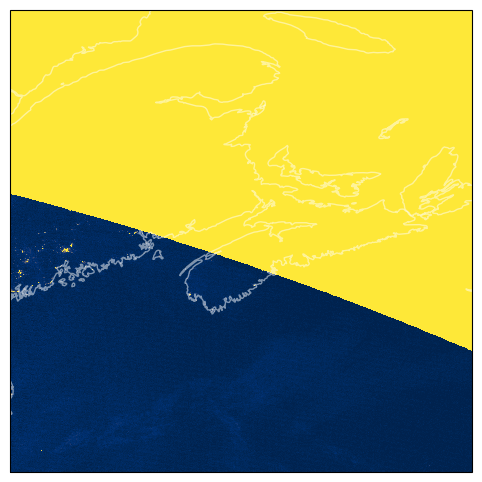

In [16]:
cmap = plt.get_cmap('cividis')
crs = ccrs.PlateCarree()

fig =  plt.figure(figsize=(6,6))
ax = plt.axes(projection=crs)
ax.coastlines(resolution='10m', color='white',alpha=0.5)
ax.pcolormesh(x, y, dnb, cmap = cmap, vmin = 0, vmax = 100)

plt.xlim((lon_min,lon_max))
plt.ylim((lat_min,lat_max))

plt.show()